# Импорт библиотек

In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb

import os
from pathlib import Path

from collections import defaultdict, Counter

import re
import datetime
from datetime import datetime

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pymorphy2

import gc

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vaceslavefimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaceslavefimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка сообщений
Загрузим сообщения из дампов каналов с вакансями сообщества **ODS**.

In [9]:
def read_json(filename):
    with open(filename, encoding='utf-8') as file:
        return json.load(file)
    

def convert_ts(ts):
    if isinstance(ts, float) and ts == ts and ts is not None:
        return datetime.fromtimestamp(ts)
    else:
        return None

In [10]:
def load_messages(*args):
    """Загружаем все сообщения в pandas DataFrame и убираем технические записи"""
    # Загрузка данных
    data = pd.DataFrame()
    for channel in args:
        messages = []
        links = os.listdir(f'_{channel}')
        for link in links:
            file = read_json(Path(f'_{channel}/' + link))
            messages = messages + file
        messages = pd.DataFrame(messages)
        messages['source'] = channel
        data = data.append(messages, sort=False)
    data = data.reset_index(drop=True)
    print(f'Загружено {len(data)} cообщений')
    
    # Убираем технические сообщения
    select = (data.upload.isna()) & (data.display_as_bot.isna()) & data.subtype.isna()
    data = data[select]
    print(f"\tУдалены технические сообщения: {sum(~select) } сообщений")
    
    # Оставляем только выбранные колонки 
    cols = ['ts', 'user', 'text', 'user_profile', 'attachments', 'edited',
           'reactions', 'thread_ts', 'reply_count', 'reply_users_count',
           'latest_reply', 'reply_users', 'replies', 'subscribed',
           'parent_user_id', 'last_read', 'client_msg_id', 'blocks', 'old_name',
           'name', 'source']
    
    # Меняем формат для дат
    data['ts'] = ((data['ts'].astype('float')).apply(convert_ts)).dt.round('s')
    data['thread_ts'] = ((data['thread_ts'].astype('float')).apply(convert_ts)).dt.round('s')
    print(f"\tДата и время округлены до секунд и переведены в datetime формат")
    
    # Очищаем и предобрабатываем текст
    data['text'] = data['text'].str.lower().str.strip()
    data['text'] = data.text.str.replace('\xa0', ' ')
    print(f"\tТекст приведен к маленьким буквам и очищен от лишних пробелов")
                    
    print(f"Осталось {len(data)} cообщений")
    
    return data.loc[:, cols].reset_index(drop=True)

In [11]:
# загрузка сообщений из каналов jobs, jobs_hr, jobs_academy_phd
messages = load_messages('jobs', 'jobs_hr', 'jobs_academy_phd')

Загружено 51222 cообщений
	Удалены технические сообщения: 7029 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 44193 cообщений


Для дальнейшего анализа нам нужно отделить сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с которых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем сообщения за 2015-2016 года.<p>
    
Другой вариант - это обучить простую модель на этой метке и разделить с ее помощью сообщения без треда.<br>

## Классификация сообщений на вакансии и комментарии

В качестве признаков будет использовать count по всем словам в сообщении.

In [20]:
df = messages.loc[~messages.thread_ts.isna(),:]

# Генерируем метку для обучения
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')


# Выбираем только нужные для обучения колнки
df = df.loc[:,['is_job', 'text']].reset_index(drop=True)

# Делим датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['text']], df['is_job'],
                                                    test_size = 0.3, random_state = 555)

# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(X_train['text'])
word_cols = countvectorizer.get_feature_names()

# Делим на train и test и обучаем модель
X_train = countvectorizer.transform(X_train['text']).toarray() 
X_test = countvectorizer.transform(X_test['text']).toarray()

gbm1 = lgb.LGBMClassifier(num_leaves=11, n_estimators=300, feature_fraction=0.1, bagging_fraction=0.3)
gbm1.fit(X_train, y_train.values)

del X_train, y_train, df
gc.collect()

173

In [21]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')

pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

df = countvectorizer.transform(messages['text']).toarray()
messages['is_job'] = gbm1.predict(df)

Accuracy для наивной модели 92.8
Accuracy для модели 99.6
F1 score 0.9689969604863222


In [23]:
# Выбираем только сообщения с вакансиями
df = messages[messages.is_job == 1].reset_index(drop=True)

# Убираем сообщения начинающиеся с тега пользователя
df = df[df['text'].str[0:2] != '<@']

print(f'Всего вакансий: {df.shape[0]}')

Всего вакансий: 3927


In [27]:
# Словарь интервалов времени для удаления из текста
TIME_RANGES_DICT = {'5/2': '', }
for i in range(1,24):
    TIME_RANGES_DICT[r'[^0123456789]{0,1}' + str(i) + r':00'] = ' '
    TIME_RANGES_DICT[r'[^0123456789]{0,1}' + str(i) + r'\.00' + r'[^0123456789]{0,1}'] = ' '
    TIME_RANGES_DICT[r'[^0123456789]{0,1}' + str(i) + r':30'] = ' '
    TIME_RANGES_DICT[r'[^0123456789]{0,1}' + str(i) + r'\.30' + r'[^0123456789]{0,1}'] = ' '
    for j in range(i,24):
        TIME_RANGES_DICT[r'c[ \t]*?' + str(i) + r' до ' + str(j) + r'[^0123456789]{0,1}'] = ' '

In [28]:
# Словарь годов для удаления из текста
YEAR_RANGES_DICT = {str(k): '' for k in range(2001,2021,1)}

In [29]:
# Ссылка
link = r'<.*?>'

# Номер телефона
tel = r'([78][-\( ]*\d{3}[-\) ]*\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3}|' + \
      r'\(\d{3}\)\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3})'

# Удаляем данные для премий
bonus = r'(\+.{0,5}?\d{2,3}.{0,25}?преми|\+ \d{2-3}-\d{2,3}|\+ \d{2,3})'

# Очищаем текст
df['clean_text'] = df.text

# Удаляем все ссылки из текста
df['clean_text'] = df.clean_text.str.replace(link, ' ')

# Удаляем телефоны из текста
df['clean_text'] = df.clean_text.str.replace(tel, ' ')

# Удаляем премии из текста
df['clean_text'] = df.clean_text.str.replace(bonus, ' ')

# Удаляем года из текста
df['clean_text'] = df.clean_text.replace(YEAR_RANGES_DICT, regex=True)

# Удаляем время из текста
df['clean_text'] = df.clean_text.replace(TIME_RANGES_DICT, regex=True)

In [30]:
def text_to_wordlist(text, remove_stopwords=True):
    text = re.sub(r"http[s]?://(?:[а-яА-Я]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
    text = re.sub("[^а-яА-Я]"," ", text)
    words = text.lower().split()
    if remove_stopwords:
        stops = stopwords.words('russian')
        words = [w for w in words if not w in stops]
    return words


def process_text(text, tokenizer, remove_stopwords=True):
    raw_texts = tokenizer.tokenize(text.strip())
    texts = []
    for raw_text in raw_texts:
        if len(raw_text) > 0:
            texts.append(text_to_wordlist(raw_text, remove_stopwords))
    return texts


def flatten(lst):
    return [item for sublist in lst for item in sublist]


def normalize(token):
    return morph.parse(token)[0].normal_form

In [31]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
morph = pymorphy2.MorphAnalyzer()

In [32]:
# токенизация, очистка от лишних символов, удаление стоп-слов
df['processed_text'] = df['text'].apply(lambda text: flatten(process_text(text, tokenizer)))

# нормализация текстов
df['normalized_text'] = df['processed_text'].apply(lambda texts: list(map(normalize, texts)))

# Подсчет наиболее частых слов

In [46]:
counter_obj = Counter(flatten(df['normalized_text']))

top_n = 60
most_frequent_words = set(list(zip(*counter_obj.most_common()[:top_n]))[0])

In [53]:
# уберем среди списка самых частых слов наименее важные в контексте вакансий:
for word in ['наш', 'так', 'это', 'м']:
    most_frequent_words.remove(word)
print(f'Всего выбранных наиболее частых слов: {len(most_frequent_words)}')

Всего выбранных наиболее частых слов: 56


In [36]:
# построение 
edges_info = defaultdict(lambda: 0)
for i, word_1 in enumerate(most_frequent_words):
    for word_2 in most_frequent_words[i + 1:]:
        for document in df['normalized_text']:
            if word_1 in document and word_2 in document:
                edges_info[(word_1, word_2)] += 1
edges_info = list(zip(*edges_info.items()))
edges = edges_info[0]
weights = edges_info[1]

In [54]:
graph_df = pd.DataFrame({
    'Source': [edge_1 for [edge_1, edge_2] in edges],
    'Target': [edge_2 for (edge_1, edge_2) in edges],
    'Weight': weights
})

# оставим ребра в графе с весами большими или равными 2
graph_df = graph_df.query(f'Weight >= 2')

In [57]:
graph_df

Source   Target  Weight
0           опыт   работа    2474
1           опыт   данные    2095
2           опыт   задача    2168
3           опыт   знание    2019
4           опыт  команда    2025
...          ...      ...     ...
1765  построение    город     285
1766  построение     язык     267
1767    кандидат    город     353
1768    кандидат     язык     256
1769       город     язык     331

[1770 rows x 3 columns]

In [58]:
# сохранение графа в CSV-файл
graph_df.to_csv('graph.csv', index=False)

# сохранение списка всех слов в CSV-файл
pd.DataFrame({
    'Source': list(most_frequent_words)
}).to_csv('points.csv', index=False)

# Построение графа слов
Для построение графа слов воспользуемся сервисом **Flourish**:

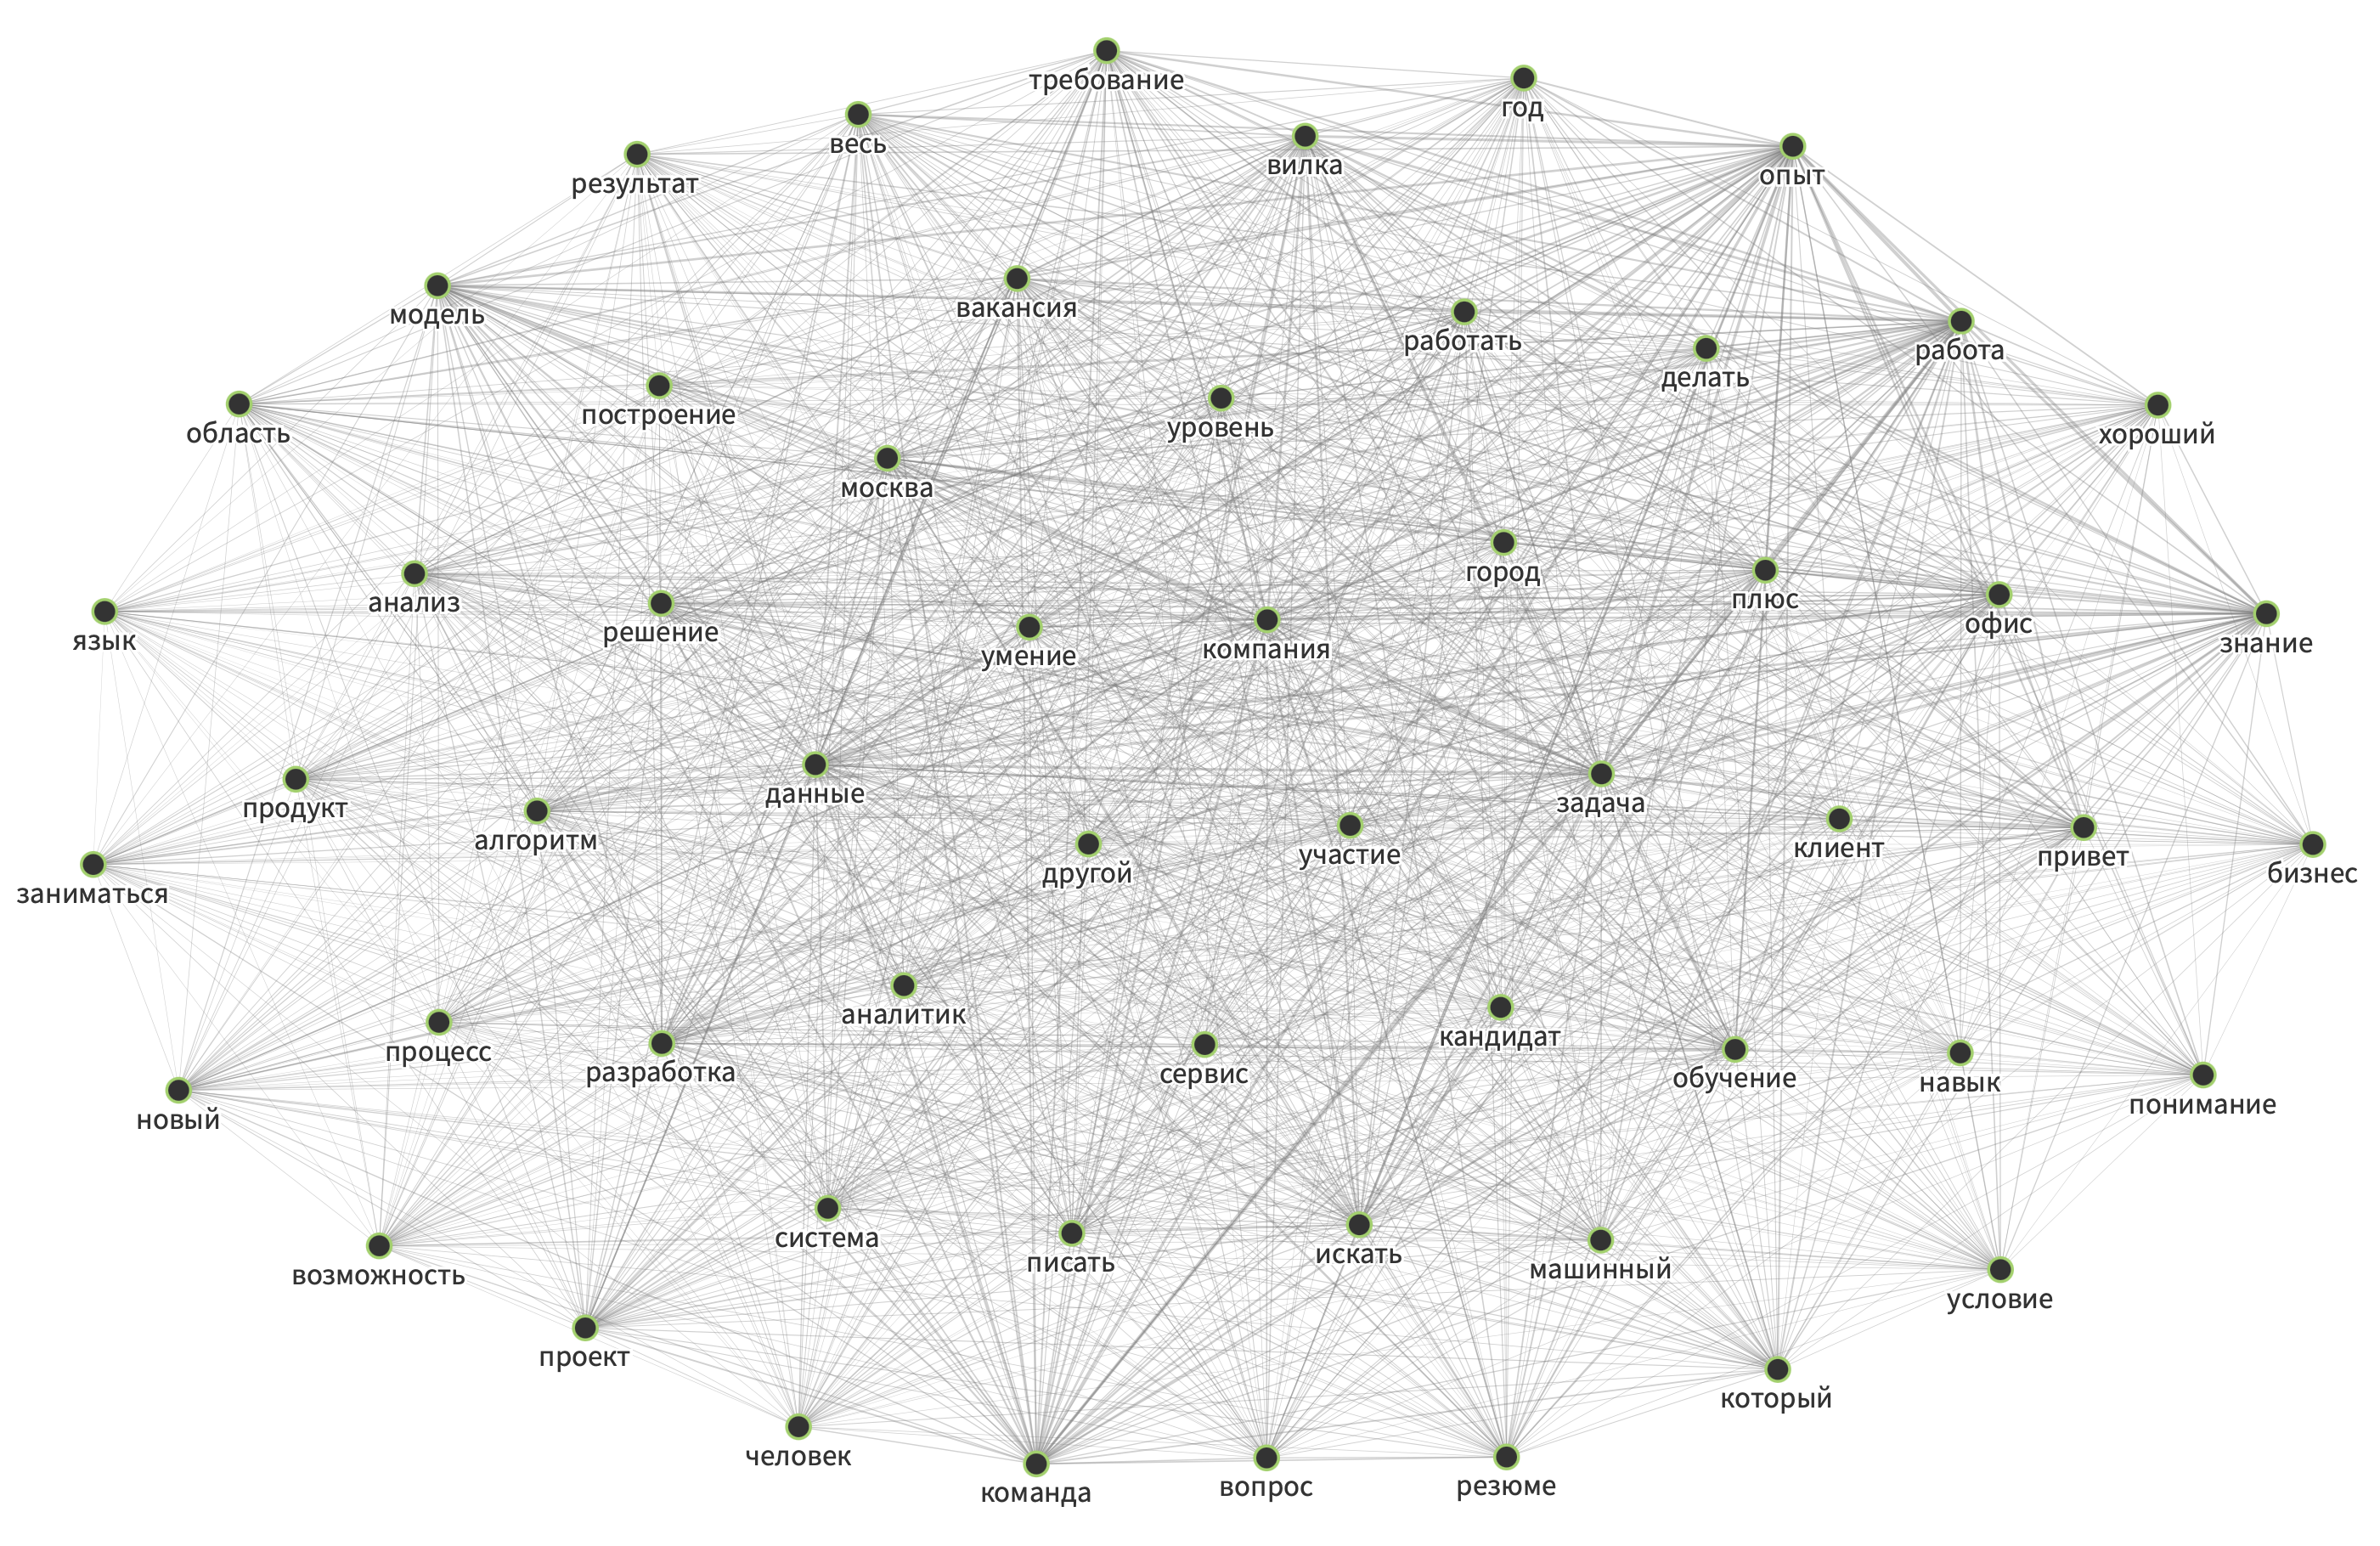

В качестве примера детально посмотрим, какие есть связи у слова "**резюме**":

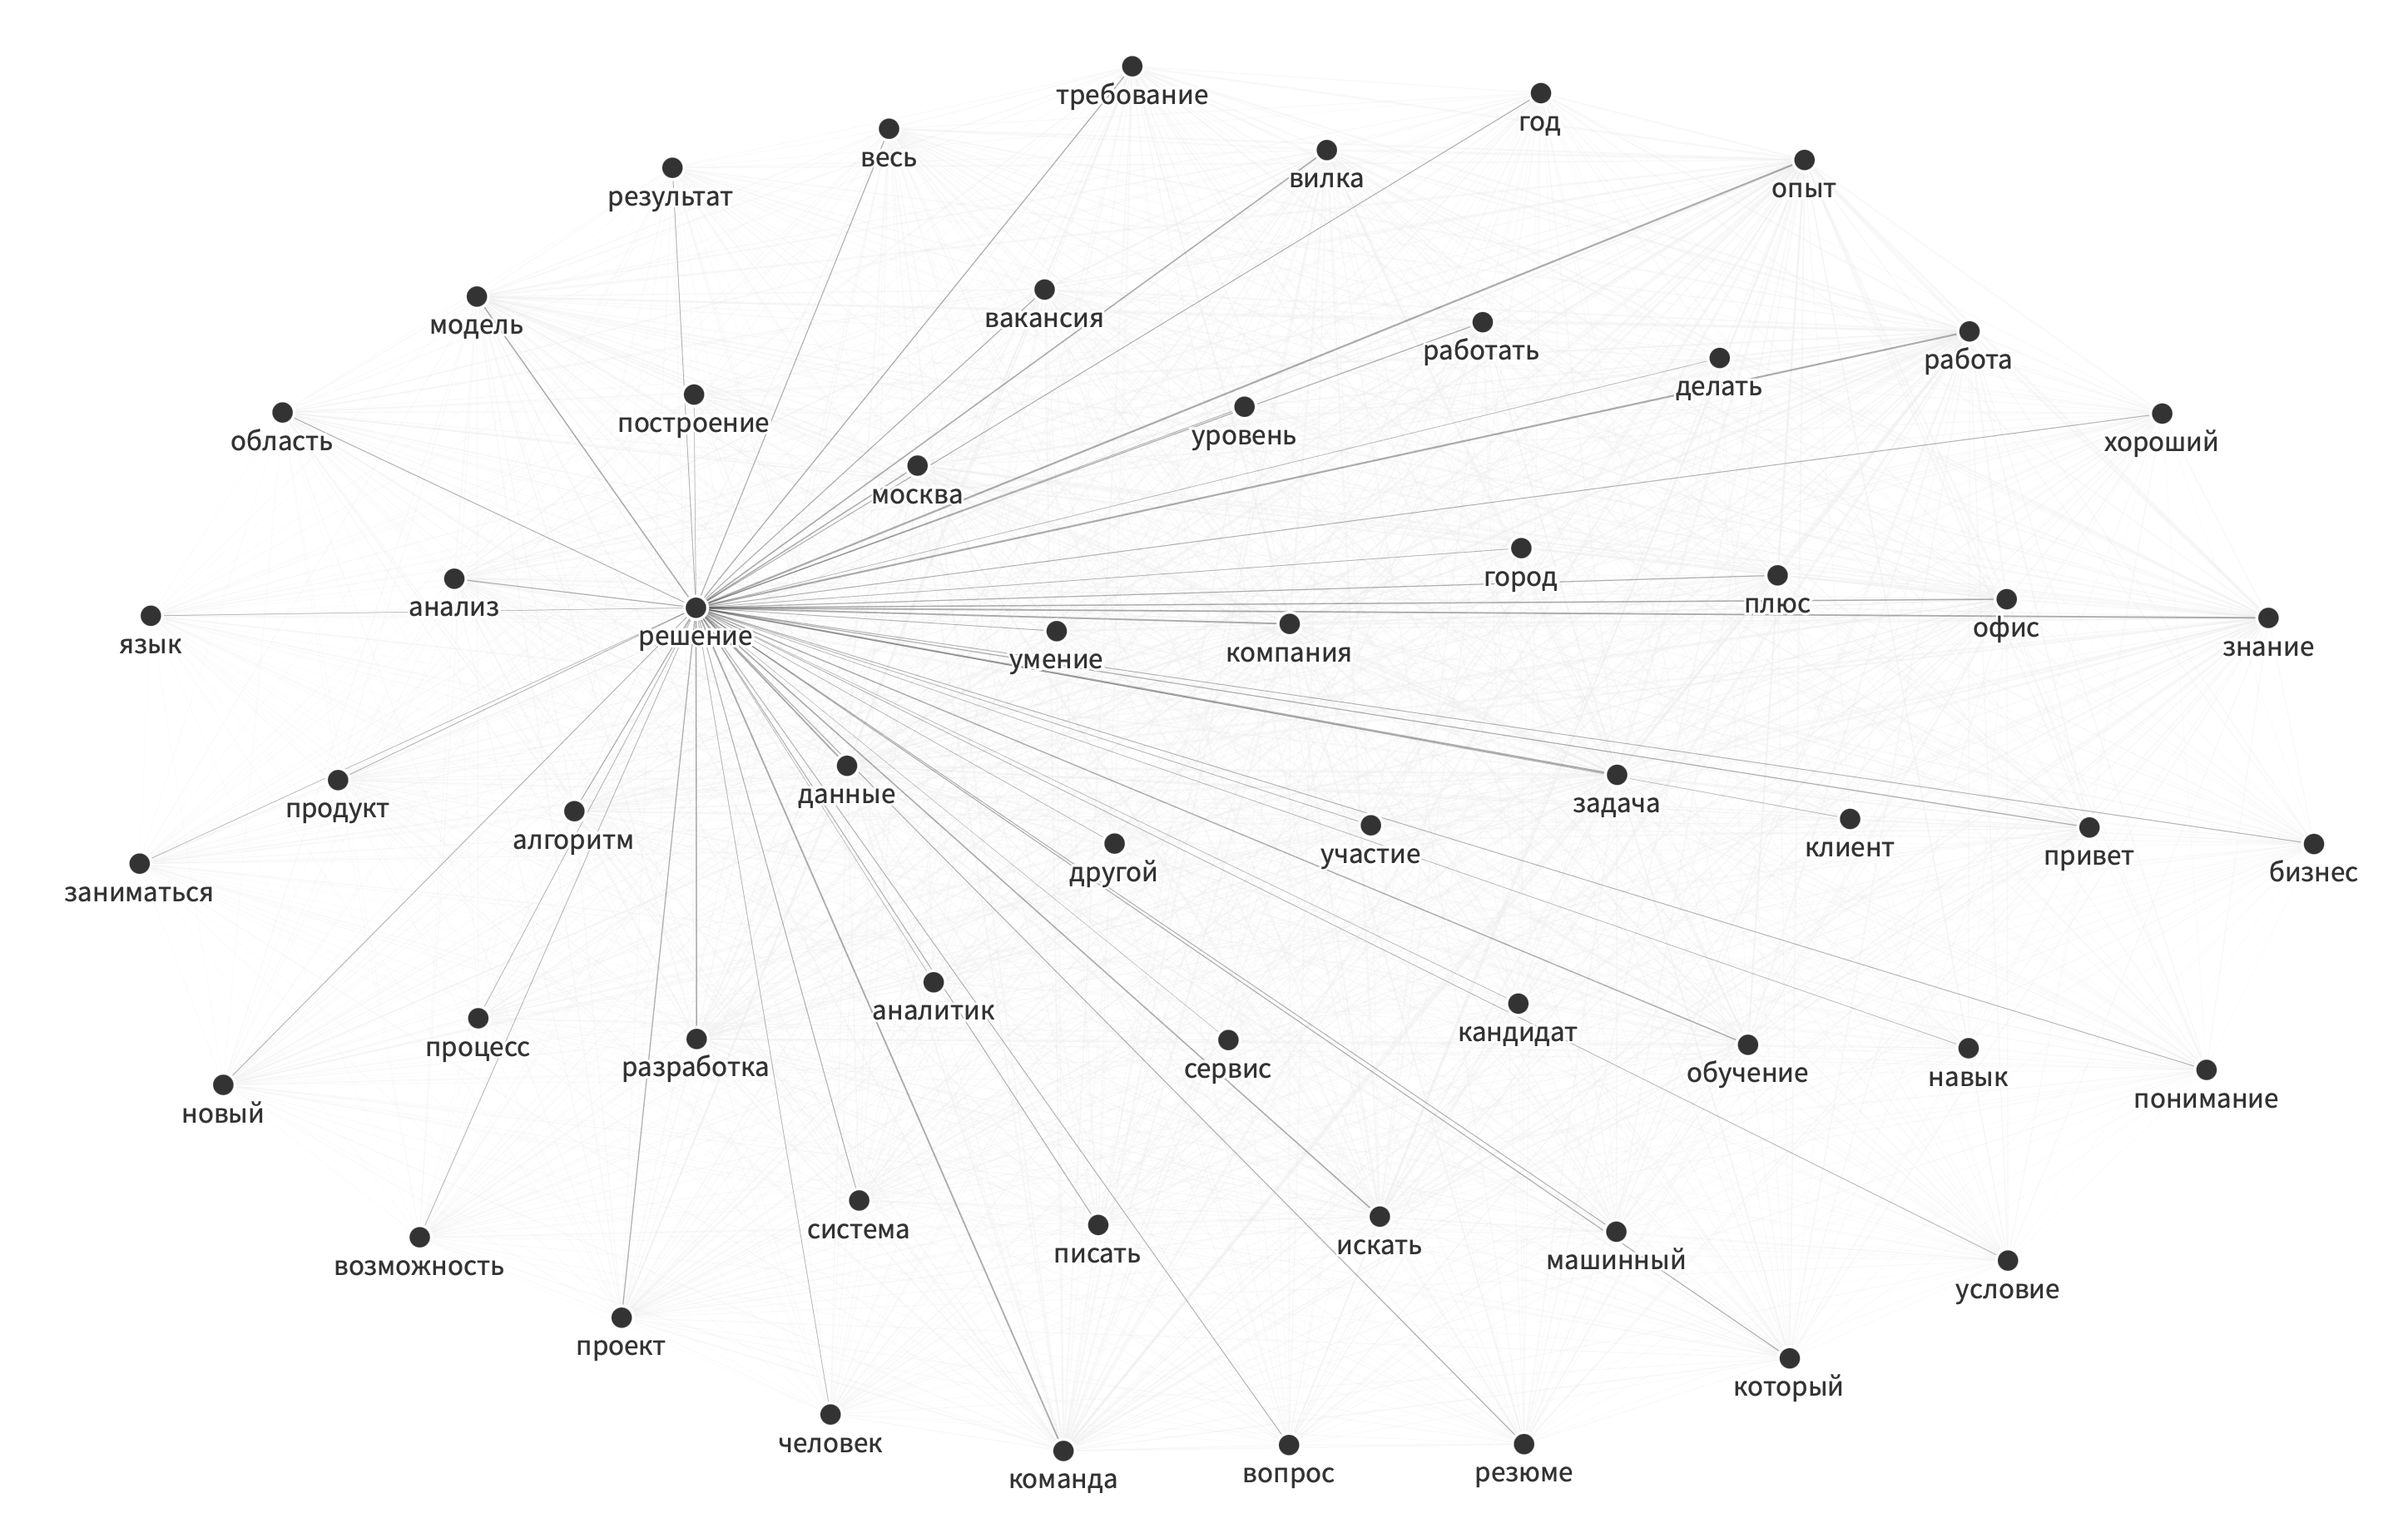